In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('/content/gdrive/MyDrive/train_heat.csv', encoding='CP949')
df = df.replace(-99, np.nan)
df = df.drop(columns='Unnamed: 0')

df['train_heat.tm'] = pd.to_datetime(df['train_heat.tm'].astype(str), format='%Y%m%d%H')
df = df.sort_values('train_heat.tm').set_index('train_heat.tm')

hour = df.index.hour
df.loc[~((hour >= 8) & (hour <= 18)), 'train_heat.si'] = 0

cols_to_impute = df.columns[df.isnull().any()].tolist()
for col in cols_to_impute:
    df[col] = df[col].interpolate(method='linear')

df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday

df['heating_season'] = df['month'].apply(lambda x: 1 if x in [10, 11, 12, 1, 2, 3, 4] else 0)
df['temp_category'] = df['train_heat.ta'].apply(lambda x: 1 if x >= 20 else 0)

def peak_time_category(hour):
    if 0 <= hour <= 6:
        return 0
    elif 6 < hour <= 12:
        return 1
    elif 12 < hour <= 18:
        return 2
    else:
        return 3

df['peak_time'] = df['hour'].apply(peak_time_category)

for lag in [1, 2, 3]:
    lag_col = f'ta_lag_{lag}'
    df[lag_col] = df['train_heat.ta'].shift(lag)
    df[lag_col] = df[lag_col].interpolate(method='linear', limit_direction='both')

base_temp = 18.0
df['HDD'] = (base_temp - df['train_heat.ta']).clip(lower=0)
df['CDD'] = (df['train_heat.ta'] - base_temp).clip(lower=0)
df['branch_temp_abs_deviation'] = (df['train_heat.ta'] - df.groupby('train_heat.branch_id')['train_heat.ta'].transform('mean')).abs()

df = df.query('`train_heat.branch_id` in ["A", "B", "D"]')

target = 'train_heat.heat_demand'
features = [
    "train_heat.ta", "train_heat.wd", "train_heat.ws", "train_heat.rn_day", "train_heat.rn_hr1",
    "train_heat.hm", "train_heat.si", "train_heat.ta_chi",
    "ta_lag_1", "ta_lag_2", "ta_lag_3", "HDD", "CDD", "branch_temp_abs_deviation"
]

df = pd.get_dummies(df, columns=["month", "weekday", "heating_season", "temp_category", "peak_time"])

df_train = df[df['year'] == 2021]
df_test = df[df['year'] == 2022]

X_train = df_train[features + [col for col in df.columns if col.startswith(('month_', 'weekday_', 'heating_season_', 'temp_category_', 'peak_time_'))]]
y_train = df_train[target]
X_test = df_test[X_train.columns]
y_test = df_test[target]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
# DeepAR Dataset
# ---------------------
class DeepARDataset(Dataset):
    def __init__(self, X, y, window_size):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.X) - self.window_size

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.window_size]
        y_seq = self.y[idx:idx+self.window_size]
        target = self.y[idx+self.window_size]
        return x_seq, y_seq.unsqueeze(-1), target

# ---------------------
# DeepAR Model
# ---------------------
class DeepAR(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.LSTM(input_size + 1, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, y_hist):
        inp = torch.cat((x, y_hist), dim=2)
        out, _ = self.rnn(inp)
        return self.fc(out[:, -1, :])

# ---------------------
# 학습 준비
# ---------------------
window_size = 48
train_dataset = DeepARDataset(X_train, y_train.values, window_size)
test_dataset = DeepARDataset(X_test, y_test.values, window_size)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepAR(input_size=X_train.shape[1], hidden_size=64, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# ---------------------
# 학습
# ---------------------
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y_hist, target in train_loader:
        x, y_hist, target = x.to(device), y_hist.to(device), target.to(device).unsqueeze(1)
        optimizer.zero_grad()
        output = model(x, y_hist)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# ---------------------
# 평가
# ---------------------


Epoch 1/20, Loss: 41094.9727
Epoch 2/20, Loss: 30911.5929
Epoch 3/20, Loss: 23455.0028
Epoch 4/20, Loss: 18059.3067
Epoch 5/20, Loss: 14225.5578
Epoch 6/20, Loss: 11474.5250
Epoch 7/20, Loss: 9544.6780
Epoch 8/20, Loss: 8147.2304
Epoch 9/20, Loss: 7148.5475
Epoch 10/20, Loss: 6428.0328
Epoch 11/20, Loss: 5921.8250
Epoch 12/20, Loss: 5675.5877
Epoch 13/20, Loss: 5389.3865
Epoch 14/20, Loss: 5128.6376
Epoch 15/20, Loss: 5048.1793
Epoch 16/20, Loss: 5038.9676
Epoch 17/20, Loss: 4836.5539
Epoch 18/20, Loss: 4751.4827
Epoch 19/20, Loss: 4787.7557
Epoch 20/20, Loss: 4714.8801


In [8]:
model.eval()
preds, trues = [], []
with torch.no_grad():
    for x, y_hist, target in test_loader:
        x, y_hist = x.to(device), y_hist.to(device)
        pred = model(x, y_hist).cpu().squeeze()
        preds.append(pred)
        trues.append(target)

y_pred = torch.cat(preds).numpy()
y_true = torch.cat(trues).numpy()

print("RMSE:", mean_squared_error(y_true, y_pred) ** 0.5)

RMSE: 74.13897357222955


In [14]:
# ------------------------------
# 지점(branch_id) 숫자 인코딩
# ------------------------------
df['branch_id_encoded'] = df['train_heat.branch_id'].astype('category').cat.codes  # 예: A=0, B=1, D=2

# train / test용 branch_id 배열 분리
branch_ids = df['branch_id_encoded'].values
branch_ids_train = branch_ids[df['year'] == 2021]
branch_ids_test = branch_ids[df['year'] == 2022]

# 지점 개수 파악 (Embedding에서 사용됨)
num_branches = df['branch_id_encoded'].nunique()


Epoch 1/20, Loss: 41036.9127
Epoch 2/20, Loss: 30458.1780
Epoch 3/20, Loss: 23207.9311
Epoch 4/20, Loss: 18075.5999
Epoch 5/20, Loss: 14318.3260
Epoch 6/20, Loss: 11640.4763
Epoch 7/20, Loss: 9727.4183
Epoch 8/20, Loss: 8614.3308
Epoch 9/20, Loss: 7622.4971
Epoch 10/20, Loss: 6875.4850
Epoch 11/20, Loss: 6393.9889
Epoch 12/20, Loss: 6122.7588
Epoch 13/20, Loss: 5857.1144
Epoch 14/20, Loss: 5708.3685
Epoch 15/20, Loss: 5579.1000
Epoch 16/20, Loss: 5505.4975
Epoch 17/20, Loss: 5391.1717
Epoch 18/20, Loss: 5336.5869
Epoch 19/20, Loss: 5326.4826
Epoch 20/20, Loss: 5324.9775


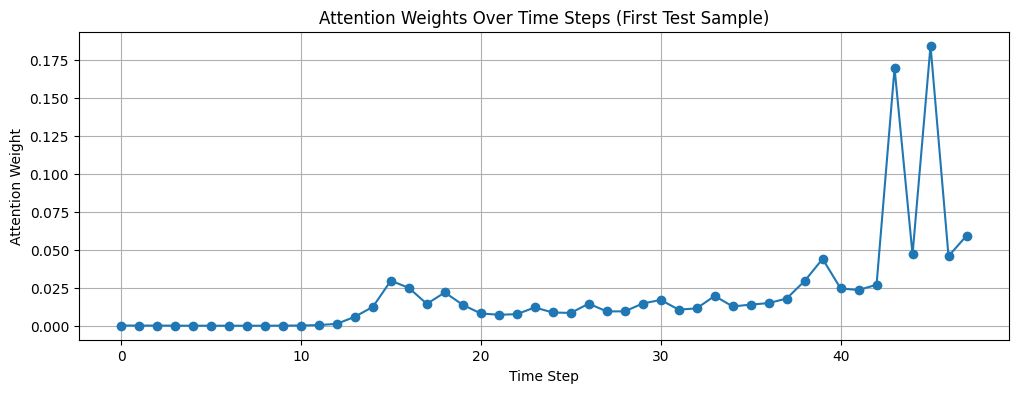

In [15]:
# DeepAR Dataset
# ---------------------
class DeepARDataset(Dataset):
    def __init__(self, X, y, window_size):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.X) - self.window_size

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.window_size]
        y_seq = self.y[idx:idx+self.window_size]
        target = self.y[idx+self.window_size]
        return x_seq, y_seq.unsqueeze(-1), target

# ---------------------
# attentionDeepAR Model
# ---------------------
# Attention 추가된 DeepAR
class AttentionDeepAR(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.LSTM(input_size + 1, hidden_size, num_layers, batch_first=True)
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, y_hist):
        inp = torch.cat((x, y_hist), dim=2)  # [B, T, input_size + 1]
        out, _ = self.rnn(inp)               # [B, T, H]
        attn_weights = torch.softmax(self.attn(out), dim=1)  # [B, T, 1]
        context = (out * attn_weights).sum(dim=1)            # [B, H]
        output = self.fc(context)                            # [B, 1]
        return output, attn_weights


# ---------------------
# 학습 준비
# ---------------------
window_size = 48
train_dataset = DeepARDataset(X_train, y_train.values, window_size)
test_dataset = DeepARDataset(X_test, y_test.values, window_size)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionDeepAR(input_size=X_train.shape[1], hidden_size=64, num_layers=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# ---------------------
# 학습
# ---------------------
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y_hist, target in train_loader:
      x, y_hist, target = x.to(device), y_hist.to(device), target.to(device).unsqueeze(1)
      optimizer.zero_grad()
      output, _ = model(x, y_hist)  # <-- 여기서 output, _ 로 분리
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


# ---------------------
# 평가 및 시각화
# ---------------------
model.eval()
x, y_hist, _ = next(iter(test_loader))
x, y_hist = x.to(device), y_hist.to(device)
with torch.no_grad():
    _, attn_weights = model(x, y_hist)

attn_weights = attn_weights.squeeze(-1)[0].cpu().numpy()  # 첫 샘플의 [T] attention
plt.figure(figsize=(12, 4))
plt.plot(attn_weights, marker='o')
plt.title("Attention Weights Over Time Steps (First Test Sample)")
plt.xlabel("Time Step")
plt.ylabel("Attention Weight")
plt.grid()
plt.show()


In [16]:
# ------------------------------
# 지점(branch_id) 숫자 인코딩
# ------------------------------
df['branch_id_encoded'] = df['train_heat.branch_id'].astype('category').cat.codes  # 예: A=0, B=1, D=2

# train / test용 branch_id 배열 분리
branch_ids = df['branch_id_encoded'].values
branch_ids_train = branch_ids[df['year'] == 2021]
branch_ids_test = branch_ids[df['year'] == 2022]

# 지점 개수 파악 (Embedding에서 사용됨)
num_branches = df['branch_id_encoded'].nunique()


Epoch 1/20, Loss: 40996.9365
Epoch 2/20, Loss: 30294.7290
Epoch 3/20, Loss: 22811.4673
Epoch 4/20, Loss: 17459.6887
Epoch 5/20, Loss: 13568.1210
Epoch 6/20, Loss: 10602.5835
Epoch 7/20, Loss: 8351.7131
Epoch 8/20, Loss: 6627.8705
Epoch 9/20, Loss: 5318.5430
Epoch 10/20, Loss: 4327.7205
Epoch 11/20, Loss: 3587.0530
Epoch 12/20, Loss: 3029.7319
Epoch 13/20, Loss: 2578.8039
Epoch 14/20, Loss: 2282.1854
Epoch 15/20, Loss: 2012.8848
Epoch 16/20, Loss: 1720.3250
Epoch 17/20, Loss: 1588.4760
Epoch 18/20, Loss: 1380.4223
Epoch 19/20, Loss: 1288.1934
Epoch 20/20, Loss: 1115.7047


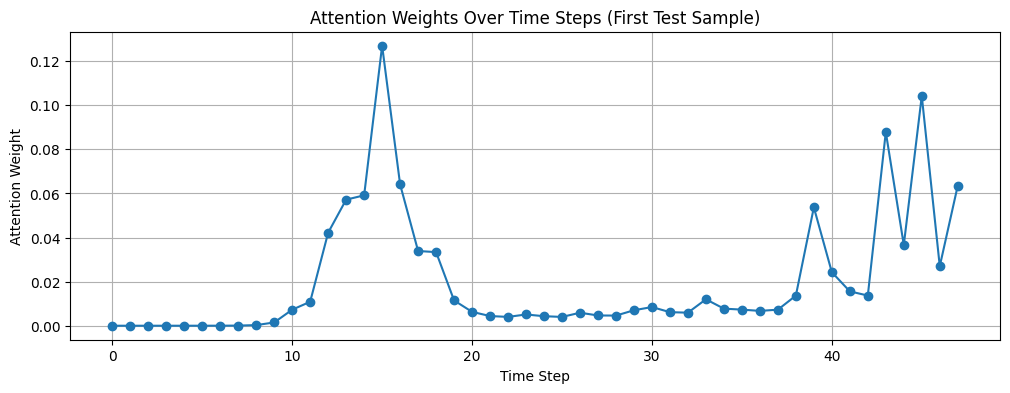

In [17]:

# ---------------------
# DeepAR Dataset 확장 (branch_id 포함)
# ---------------------
class DeepARDataset(Dataset):
    def __init__(self, X, y, branch_ids, window_size, num_branches):
        self.X = torch.tensor(X, dtype=torch.float32)                 # [N, input_size]
        self.y = torch.tensor(y, dtype=torch.float32)                 # [N]
        self.branch_ids = torch.tensor(branch_ids, dtype=torch.long)  # [N]
        self.window_size = window_size
        self.num_branches = num_branches

    def __len__(self):
        return len(self.X) - self.window_size

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.window_size]                      # [T, input_size]
        y_seq = self.y[idx:idx+self.window_size].unsqueeze(-1)        # [T, 1]
        target = self.y[idx+self.window_size]                         # scalar
        branch_id = self.branch_ids[idx+self.window_size]             # scalar
        return x_seq, y_seq, target, branch_id


# ---------------------
# Attention 기반 DeepAR 모델 확장 (branch_id Embedding 포함)
# ---------------------
class AttentionDeepAR(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_branches, embedding_dim=8):
        super().__init__()
        self.embedding = nn.Embedding(num_branches, embedding_dim)
        self.rnn = nn.LSTM(input_size + 1 + embedding_dim, hidden_size, num_layers, batch_first=True)
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, y_hist, branch_ids):
        batch_size, seq_len, _ = x.size()
        emb = self.embedding(branch_ids)                          # [B, emb_dim]
        emb_seq = emb.unsqueeze(1).repeat(1, seq_len, 1)          # [B, T, emb_dim]
        inp = torch.cat((x, y_hist, emb_seq), dim=2)              # [B, T, input_size+1+emb_dim]
        out, _ = self.rnn(inp)                                     # [B, T, hidden_size]
        attn_weights = torch.softmax(self.attn(out), dim=1)       # [B, T, 1]
        context = (out * attn_weights).sum(dim=1)                  # [B, hidden_size]
        output = self.fc(context)                                  # [B, 1]
        return output, attn_weights


# ---------------------
# 학습 준비 (예시)
# ---------------------
window_size = 48
num_branches = 10  # 지점 개수 예시, 실제 데이터에 맞게 변경

train_dataset = DeepARDataset(X_train, y_train.values, branch_ids_train, window_size, num_branches)
test_dataset = DeepARDataset(X_test, y_test.values, branch_ids_test, window_size, num_branches)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionDeepAR(input_size=X_train.shape[1], hidden_size=64, num_layers=2, num_branches=num_branches, embedding_dim=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# ---------------------
# 학습 루프
# ---------------------
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y_hist, target, branch_id in train_loader:
        x, y_hist, target, branch_id = x.to(device), y_hist.to(device), target.to(device).unsqueeze(1), branch_id.to(device)
        optimizer.zero_grad()
        output, _ = model(x, y_hist, branch_id)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# ---------------------
# 평가 및 Attention 시각화
# ---------------------
model.eval()
x, y_hist, _, branch_id = next(iter(test_loader))
x, y_hist, branch_id = x.to(device), y_hist.to(device), branch_id.to(device)
with torch.no_grad():
    _, attn_weights = model(x, y_hist, branch_id)

attn_weights = attn_weights.squeeze(-1)[0].cpu().numpy()  # 첫 샘플 attention
plt.figure(figsize=(12, 4))
plt.plot(attn_weights, marker='o')
plt.title("Attention Weights Over Time Steps (First Test Sample)")
plt.xlabel("Time Step")
plt.ylabel("Attention Weight")
plt.grid()
plt.show()


In [18]:
model.eval()
preds, trues = [], []

with torch.no_grad():
    for x, y_hist, target, branch_id in test_loader:
        x, y_hist = x.to(device), y_hist.to(device)
        branch_id = branch_id.to(device)
        pred, _ = model(x, y_hist, branch_id)
        preds.append(pred.cpu().squeeze())
        trues.append(target)

y_pred = torch.cat(preds).numpy()
y_true = torch.cat(trues).numpy()

from sklearn.metrics import mean_squared_error
print("RMSE:", mean_squared_error(y_true, y_pred) ** 0.5)

RMSE: 34.200801514273756
